In [146]:
import json
import pandas as pd
import numpy as np

## Ribonanza

In [147]:
def rename_families(x):
    if x == '5s' or x == '16s' or x == '23s' or 'rRNA' in x:
        return 'rRNA'
    if x == 'grp1' or x == 'group_I_intron':
        return 'Introns'
    if x == 'grp2' or 'intron' in x:
        return 'Introns'
    if x == 'srp' or x == 'SRP':
        return 'SRP'
    if x == 'telomerase':
        return 'telomerase'
    if x == 'RNaseP':
        return 'rRNA'
    else: 
        return x

## RNAStralign

In [148]:
data = json.load(open('../RNAStralign/data.json'))
from rouskinhf import convert
data = convert(
                'ct',
                file_or_folder='../RNAStralign/data',
                name='RNAStralign',
                filter=0
            )

new_data = {}
refs = {}
for ref, attr in data.items():
    if '__####' in ref:
        family, ref = ref.split('__####')
        attr['family'] = family
    if not ref in refs:
        refs[ref] = 0
    else:
        while f'{ref}_{refs[ref]}' in refs:
            refs[ref] += 1
        ref = f'{ref}_{refs[ref]}'
    new_data[ref] = attr
    
data = new_data
families = pd.DataFrame.from_dict(data, orient='index')['family'].apply(lambda x: x.split('__')[0].replace('_database', '')).apply(rename_families)
fam_rnastralign = pd.DataFrame(families.value_counts()).rename(columns={'count': 'RNAStralign'})
len_rnastralign = pd.DataFrame.from_dict(data, orient='index')['sequence'].apply(len)
fam_rnastralign

Parsing ct files: 100%|██████████| 37149/37149 [00:24<00:00, 1505.37it/s]


Drop 3949 datapoints with None values (null sequence or reference)


,RNAStralign
family,
rRNA,21904
tRNA,9234
Introns,453
SRP,164
tmRNA,133
telomerase,37


## archiveII

In [149]:
import os
fam_archivII = {}
len_archivII = []
for file in os.listdir('/Users/yvesmartin/data/archiveII'):
    if not file.endswith('.seq'):
        continue
    seq = open(f'/Users/yvesmartin/data/archiveII/{file}').read().split('\n')[2]
    family = file.split('_')[0]
    fam_archivII[family] = fam_archivII.get(family, 0) + 1
    len_archivII.append(len(seq))
len(len_archivII)
fam_archivII

{'5s': 1283,
 'tRNA': 557,
 'srp': 928,
 'tmRNA': 462,
 'RNaseP': 454,
 'grp1': 115,
 '23s': 35,
 '16s': 110,
 'telomerase': 37,
 'grp2': 11}

In [150]:
fam_archivII_new = {}
for k, v in fam_archivII.items():
    fam_archivII_new[rename_families(k)] = fam_archivII_new.get(rename_families(k), 0) + v
fam_archivII = pd.DataFrame.from_dict(fam_archivII_new, orient='index').rename({0: 'archiveII'}, axis=1)
fam_archivII

,archiveII
rRNA,1882
tRNA,557
SRP,928
tmRNA,462
Introns,126
telomerase,37


In [160]:
assert len(len_archivII) == fam_archivII['archiveII'].sum()

## bpRNA (from paper)

In [151]:
import pandas as pd
from io import StringIO

# Provided data
data = """
RNA Type,bpRNA-1m,bpRNA-1m(90)
Transfer RNA,35622,3383
16S Ribosomal RNA,17641,1067
5S Ribosomal RNA,477,607
Signal Recognition Particle RNA,1603,388
Ribonuclease P RNA,1425,605
Transfer Messenger RNA,161,449
Group I Intron,237,123
23S Ribosomal RNA,191,72
Hammerhead Ribozyme,186,77
Group II Intron,131,101
"""

# Create a DataFrame
bprna = pd.read_csv(StringIO(data), delimiter=',')#.set_index('RNA Type')
def rename_families_bp(x):
    return {
    'Transfer RNA': 'tRNA',
    '16S Ribosomal RNA': 'rRNA',
    '5S Ribosomal RNA': 'rRNA',
    'Signal Recognition Particle RNA': 'Other',
    'Ribonuclease P RNA': 'Other',
    'Transfer Messenger RNA': 'tmRNA',
    'Group I Intron': 'Introns',
    '23S Ribosomal RNA': 'rRNA',
    'Hammerhead Ribozyme': 'rRNA',
    'Group II Intron': 'Introns',
    }.get(x, x)
bprna['RNA Type'] = bprna['RNA Type'].apply(rename_families_bp)
bprna = bprna.groupby('RNA Type').sum()
bprna

,bpRNA-1m,bpRNA-1m(90)
RNA Type,,
Introns,368,224
Other,3028,993
rRNA,18495,1823
tRNA,35622,3383
tmRNA,161,449


### bpRNA from data

In [152]:
from rouskinhf import convert

data = convert(
    'bpseq',
    '/Users/yvesmartin/data/bpRNA',
    name='bpRNA',
    path_out='data',
    filter=False
)
len_bprna = [len(dp['sequence']) for dp in data.values()]
len(len_bprna)

Parsing bpseq files: 100%|██████████| 102318/102318 [00:34<00:00, 2970.80it/s]


Drop 5064 datapoints with None values (null sequence or reference)


97254

In [153]:
len_bprna90 = [len(l) for l in open('/Users/yvesmartin/data/bpRNA/bpRNA_1m_90.fasta').read().split('\n')[1::2]]

# Aggregate

In [173]:
df = pd.concat([bprna, fam_rnastralign, fam_archivII], axis=1)
df.columns = ['bpRNA-1m', 'bpRNA-1m(90)', 'RNAStralign', 'ArchiveII']
# df = df.fillna(0).astype(int)
df_family = df.copy()
df_family.loc['total'] = df_family.sum()
df_family.loc['total', 'bpRNA-1m'] = 102_318
df_family.loc['total', 'bpRNA-1m(90)'] = len(len_bprna90)
df_family.loc['total', 'RNAStralign'] = len(len_rnastralign)
df_family.loc['total', 'ArchiveII'] = len(len_archivII)
# others = total - df_family.sum()
df_family.loc['Other'] = df_family.loc['total'] - np.nansum(df_family.loc[[c for c in df_family.index if c != 'total']].values, axis=0)
# 
# assert df_family.loc[df_family.index[:-1]].sum().sum() == df_family.loc['total'].sum()
df_family.drop('total', inplace=True)
df_family


,bpRNA-1m,bpRNA-1m(90),RNAStralign,ArchiveII
Introns,368.0,224.0,453.0,126.0
Other,44644.0,21498.0,0.0,0.0
rRNA,18495.0,1823.0,21904.0,1882.0
tRNA,35622.0,3383.0,9234.0,557.0
tmRNA,161.0,449.0,133.0,462.0
SRP,NaN,NaN,164.0,928.0
telomerase,NaN,NaN,37.0,37.0


In [174]:
# one value per bin
def make_histograms(l):
    min_val = 0
    max_val = 4400
    bin_size = 100
    bins = np.arange(min_val + bin_size/2, max_val - bin_size/2, bin_size)
    hist, bins = np.histogram(l, bins=max_val//bin_size, range=(min_val, max_val))
    return hist, bins
hists = {
    'bpRNA-1m': make_histograms(len_bprna),
    'bpRNA-1m(90)': make_histograms(len_bprna90),
    'RNAStralign': make_histograms(len_rnastralign),
    'ArchiveII': make_histograms(len_archivII),
}

### Plot as piecharts

In [175]:
horizontal_spacing = 0.08
vertical_spacing = 0.2
height = 600
width = 1200

In [178]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots



# first row is piechart of family distribution
# second row is histogram of sequence length distribution
# I want it to look like a paper figure
fig = make_subplots(rows=2, cols=4, specs=[[{'type': 'domain'}]*4, [{'type': 'histogram'}]*4], 
                    subplot_titles=[f"{name} (N={len(l)})" for l in [len_bprna, len_bprna90, len_rnastralign, len_archivII]] + ['']*4,
                    vertical_spacing=vertical_spacing,
                    horizontal_spacing=horizontal_spacing,
                    row_heights=[0.5, 0.2],
)

for i in fig['layout']['annotations']:
    i['font'] = dict(size=22)
    
for i, name in enumerate(hists.keys()):
    fig.add_trace(go.Pie(
        labels=df_family.index,
        values=df_family[name],
        name=name,
        textinfo=f'percent',
        textposition='auto',
        showlegend=i==3,
        sort=True,
        # legennd location
        # domain={'x': [0.0, 0.25], 'y': [0.5, 1.0]} if i == 0 else {'x': [0.25, 0.5], 'y': [0.5, 1.0]} if i == 1 else {'x': [0.5, 0.75], 'y': [0.5, 1.0]} if i == 2 else {'x': [0.75, 1.0], 'y': [0.5, 1.0]},
    ), row=1, col=i+1)
    fig.add_trace(go.Bar(
        x=hists[name][1][:-1],
        y=hists[name][0],
        name=name,
        showlegend=False,
        marker_color='rgb(0, 0, 0)',
    ), row=2, col=i+1)
    # fig.update_yaxes(row=2, col=i+1,  range=[0, 50000])
    fig.update_xaxes(row=2, col=i+1, range=[-100, 2000], tick0=0, dtick=2000)
    # make bar width constant
    # add horitontal lines
    fig.update_layout(barmode='overlay', bargap=0.1, bargroupgap=0.1)

# write 'sequence length' at the bottom, centered
fig.add_annotation(dict(
    x=0.5,
    y=-0.15,
    text='Sequence length (bin size: 100)',
    showarrow=False,
    font=dict(size=22),
    xref='paper',
    yref='paper',
    xanchor='center',
    yanchor='bottom',
))

fig.add_annotation(dict(
    x=-0.06,
    y=0.63,
    text='Families',
    showarrow=False,
    font=dict(size=22),
    xref='paper',
    yref='paper',
    xanchor='center',
    yanchor='bottom',
    textangle=-90
), 
)

fig.add_annotation(dict(
    x=-0.06,
    y=0.03,
    text='Count',
    showarrow=False,
    font=dict(size=22),
    xref='paper',
    yref='paper',
    xanchor='center',
    yanchor='bottom',
    textangle=-90
), 
)

fig.update_layout(
    height=height,
    width=width,
    title_x=0.5,
    title_y=0.95,
    font_size=20,
    font_family='Arial',
    font_color='black',
    legend_font_size=20,
    legend_font_family='Arial',
    legend_font_color='black',
    legend_x=1.03,
    legend_y=0.95,
    # legend_orientation='h',
    legend_traceorder='normal',
    legend_bordercolor='black',
    template="plotly_white",

)






## bpRNA (old)


In [ ]:
data = json.load(open('../bpRNA/data/bpRNA/data.json'))
df = pd.DataFrame.from_dict(data, orient='index').reset_index().rename(columns={'index': 'reference'})
df['family'] = df['reference'].apply(lambda x: x.split('_')[1])
df['sequence'] = df['sequence'].apply(lambda x: x.replace('T', 'U'))
df.set_index('reference', inplace=True)
print(len(df))  

66715


In [ ]:
df['family'].value_counts()

family
RFAM     39601
CRW      24552
SRP        723
PDB        533
SPR        483
RNP        419
tmRNA      404
Name: count, dtype: int64

### bpRNA/labeled

In [ ]:
valid_labels = list(fam_archivII.keys()) + list(fam_rnastralign.keys()) + ['SPR', 'RNP', 'ncRNA']
df['family'] = df['family'].apply(lambda x: 'ncRNA' if x == 'PDB' else x)
df_labeled = df[df['family'].isin(valid_labels)].copy()
df_labeled['family'].value_counts()

family
ncRNA    533
SPR      483
RNP      419
Name: count, dtype: int64

### bpRNA/unlabeled

In [ ]:
df_un = df[~df['family'].isin(valid_labels)].copy()
df_un = df_un[['sequence']].reset_index().rename(columns={'index': 'reference'})
len(df_un)

65280

In [ ]:
df_un

,reference,sequence
0,bpRNA_CRW_9331,CGUGUCGUGAGAUGUUGGGUUAAGUCCCGCAACGAGCGCAACCCUU...
1,bpRNA_CRW_16343,CCUGACGACCAUAGCGAGCGGGUCCCACCUGACCCCAUGCCGAACU...
2,bpRNA_CRW_14876,GAUGAACGCUGGCGGCGUGCCUAAUACAUGCAAGUCGAGCGAACAG...
3,bpRNA_CRW_50032,GUCAGGAUAGCUCAGUUGGUAGAGCAGAGGACUGAAAAUC
4,bpRNA_CRW_40524,AGGGCCUAUAGCUCAGUUGGUUAGAGCACACGCCUGAUAAGCGUGA...
...,...,...
65275,bpRNA_CRW_43706,GGGUCUGUAGCUCAGUCGGUUAGAGCAGGGGACUCAUAAUCCCUUG...
65276,bpRNA_CRW_15161,GAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUACAUGCAA...
65277,bpRNA_RFAM_19577,UGUGCAUCGUGGUCAAAUGCUCAGACUCCUGUGGUGGCUGCUCAUG...
65278,bpRNA_RFAM_23681,CCCAAAGGUUCCCUCAGGCUGAAUGGAAACCAGCCAGAGAGUGUAA...


### Add labels from external databases through sequence matching

#### Rfam fasta files

In [ ]:
rfam = pd.read_csv('/Users/yvesmartin/src/supermodels-data/rfam/data/rfam.csv')
rfam = rfam[['ref_desc', 'sequence', 'family_name', 'full_family_name', 'clan_name']]
rfam['sequence'] = rfam['sequence'].apply(lambda x: x.replace('T', 'U'))

In [ ]:
df = pd.merge(df_un, rfam, on='sequence', how='left')
df.sort_values(by='family_name', inplace=True, na_position='last')
df.drop_duplicates(subset=['reference'], inplace=True, keep='first')
df

,reference,sequence,ref_desc,family_name,full_family_name,clan_name
166982,bpRNA_RFAM_23074,UUAUUUUUAACUUUUAUCAGGGCUAGCUUUUGGGUAAUUGAUAAAA...,"Lactobacillus casei ATCC 334, complete genome.",23S-methyl,23S methyl RNA motif,NaN
34914,bpRNA_RFAM_23059,UUUUCAUUGGUUUUUAUCAGGUUCCUGUUCUGAUAAAAGUUAGUGA...,"Enterococcus sp. 10A9_DIV0425 scaffold00003, w...",23S-methyl,23S methyl RNA motif,NaN
194416,bpRNA_RFAM_23075,UAUUAAUUUGUUUCAAUCUUUCCUGUUAUGAUUAAAGCAAAUUAGU...,"Lactococcus lactis subsp. cremoris SK11, compl...",23S-methyl,23S methyl RNA motif,NaN
176712,bpRNA_RFAM_23069,CAUUCGUUGGUUUAAAUCAAACCUGUUAUGAUUUAAGUUAGCGAGU...,"Streptococcus pyogenes MGAS10750, complete gen...",23S-methyl,23S methyl RNA motif,NaN
126866,bpRNA_RFAM_23065,CGUUUGGUAGUUAACAUCGACAUGUCGUUGGUGACUACCGAGUUGU...,Lactobacillus plantarum WCFS1 complete genome,23S-methyl,23S methyl RNA motif,NaN
...,...,...,...,...,...,...
225163,bpRNA_CRW_54700,AAAGACUCAGUCCUAACCUUACUAUUGGUUUUUGCUAGACAUAUAC...,NaN,NaN,NaN,NaN
225164,bpRNA_CRW_43706,GGGUCUGUAGCUCAGUCGGUUAGAGCAGGGGACUCAUAAUCCCUUG...,NaN,NaN,NaN,NaN
225165,bpRNA_CRW_15161,GAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUACAUGCAA...,NaN,NaN,NaN,NaN
225186,bpRNA_RFAM_23681,CCCAAAGGUUCCCUCAGGCUGAAUGGAAACCAGCCAGAGAGUGUAA...,NaN,NaN,NaN,NaN


#### CRW 

In [ ]:
data = pd.DataFrame.from_dict(json.load(open('../CRW/crw.json')), orient='index').reset_index().rename(columns={'index': 'reference', 'family':'family_name'})[['sequence', 'family_name']]
df = pd.merge(df, data, on='sequence', how='left')
df['family_name'] = df.apply(lambda x: x['family_name_x'] if pd.isnull(x['family_name_y']) else x['family_name_y'], axis=1)
df.drop(['family_name_x', 'family_name_y'], axis=1, inplace=True)
df['family_name'].value_counts()

family_name
tRNA             3620
5S_rRNA           848
tmRNA             748
RNaseP_bact_a     450
SAM               433
                 ... 
TtnuHACA21          1
mir-423             1
mir-197             1
BMV3_UPD-PK1        1
mir-995             1
Name: count, Length: 1604, dtype: int64

In [ ]:
translation_family_name = {
    'sRNA': ['sRNA', 'rli', 'rivX', 'CC', 'STnc', 'sau-', 'Atu_', 'GlsR', '6C', 'ArcZ', 'Bsr', 'C0', 'CyaR_RyeE', 'whalefall-1', 'tpke11', 'tfoR',\
        't44', 'sro', 'FsrA', 'sraA', 'ryfA', 'GadY', 'GcvB', 'Hgc', 'IS009', 'InvR', 'MtlS', 'OmrA-B', 'OrzO-P', 'OxyS', 'PrrF', 'Qrr', 'RybB', 'RydC', 'SgrS',\
        'Spot_42', 'Sra'
            ],
    'tRNA': ['tRNA', 'TLS-PK'],
    'rRNA': ['rRNA', '5s', '5S_rRNA', '16s', '16S_rRNA', '23s', '23S_rRNA', 'RF_site', 'ribozyme', 'GOLLD'],
    'ncRNA': ['ncRNA', 'rdlD', 'NRON', 'CopA', 'DicF', 'uc_338', 'Dicty_Class_I_RNA', 'DsrA', 'FourU', 'srg1', 'sok', 'symR', 'sar', 'rncO', \
            'rydB', 'msr', 'IS102', 'IS128', 'MicC', 'MicF', 'NrrF', 'NsiR1', 'Plasmid_RNAIII','RNA-OUT', 'RNAI','RUF', \
             'RprA', 'Rsa', 'SprD'
                ],
    'group_I_intron': ['grp1'],
    'group_II_intron': ['grp2', 'group-II'],
    'SRP': ['srp', 'SRP'],
    'RNaseP': ['RNaseP'],
    'crRNA': ['CRISPR'],
    'RNP': ['HACA'],
    'snRNA': ['snRNA', 'sn', 'Gl_U', 'SNORA', 'U1', 'U7', 'U3', 'VA', 'SCARNA'],
    'microRNA': ['mir-', 'MIR', 'lsy-6'],
    'virus': ['virus', 'CuYV_BPYV', 'SPCSV', 'HAV', 'BMV3_UPD', 'Rubella_3', 'HIV', 'HBV', 'IRES'],
    'tmRNA': ['tmRNA'],
    'mRNA': ['SAM', 'mini-ykkC', 'FIE3'],
    'CRE': ['sucA', 'Antizyme_FSE', 'CAESAR', 'ylbH', 'yjdF', 'ydaO-yuaA', 'ybhL', 'wcaG', 'G-CSF_SLDE', 'GABA3', 'GAIT', 'speF', 'GP_knot', 
            'Gurken', 'K_chan_RES', 'Mg_sensor', 'PyrR', 'RtT', 'SECIS_'                                   ],
    'other': ['IMES-3', 'isrK', 'isrL', 'DapZ', 'ppoRNA', 'DNA', 'RyhB'],
    'telomerase': ['tp2'],
    'motif': ['MS2', 'OLE', 'PYLIS_'],
}

translation_clan_name = {
    'snRNA': ['7SK'],
    'ncRNA': ['Csr_Rsm_clan', 'FinP-traJ','Glm', 'suhB'],
    'sRNA': ['RyeA-RyeB', 'LhrC'],
    'RNaseP': ['RNaseP'],
    'mRNA': ['SL'],
}

translation_family_description = {
    'mRNA': ['riboswitch', 'UTR', 'mRNA', 'promoter', ],
    'snRNA': ['spliceosomal', 'Small nucleolar', 'snoRNA', 'Small Nucleolar RNA', 'small nucleolar'],
    'sRNA': ['sRNA', 'small RNA', 'AniS', 'Anti-Q RNA', 'Hfq binding', 'antisense','anti-sense', 'Antisense', 'anti-toxin', 'Short', 'antitoxin'],
    'virus': ['virus'],
    'microRNA': ['microRNA'],
    'tRNA': ['tRNA'],
    'tmRNA': ['tmRNA'],
    'crRNA': ['CRISPR'],
    'telomerase': ['telomerase'],
    '23S_rRNA': ['23S'],
    '6S_rRNA': ['6S'],
    'motif': ['pseudoknot', 'Hammerhead', 'motif', 'Stem loopII regulatory element in POLB', 'Pseudoknot'],
    'CRE': ['Alpha operon ribosome binding site', 'leader', 'cis-regulatory element', 'element'],
    'rRNA': ['rRNA', 'Ribosomal', 'ribosomal', 'ribozyme', 'pRNA', 'ribosome'],
    'ncRNA': ['Y RNA', 'thermometer', 'noncoding', 'SscA', 'Non-coding'], 
    'group_I_intron': ['Group I'],
}

def clean_family(row):
    x = row['clan_name']
    if not pd.isna(x):
        for family, v in translation_clan_name.items():
            for vv in v:
                if vv in x:
                    return family

    x = row['family_name']
    if pd.isna(x):
        return 'other'
    for family, v in translation_family_name.items():
        for vv in v:
            if vv in x:
                return family
            
    full_family_name = row['full_family_name']
    if pd.isna(full_family_name):
        return 'other'
    for family, keywords in translation_family_description.items():
        for kw in keywords:
            if kw in full_family_name:
                return family     
    return 'other'

df_temp = df.copy()
df_temp['family'] = df.apply(clean_family, axis=1)
df_temp['length'] = df_temp['sequence'].apply(len)
df_temp.set_index('reference', inplace=True)
print(df_temp.value_counts('family')/len(df_temp))

family
other              0.515322
snRNA              0.118239
tRNA               0.058508
sRNA               0.051584
mRNA               0.037752
microRNA           0.035291
rRNA               0.028138
virus              0.027771
CRE                0.027450
group_II_intron    0.021169
motif              0.016675
tmRNA              0.013786
ncRNA              0.013297
RNaseP             0.012548
SRP                0.011998
crRNA              0.004020
6S_rRNA            0.002277
group_I_intron     0.001574
telomerase         0.001452
RNP                0.000856
23S_rRNA           0.000290
Name: count, dtype: float64


In [ ]:
## Merge with labeled
df_final = pd.concat([df_labeled, df_temp])[['sequence', 'family']]#.value_counts('family')# / len(pd.concat([df_labeled, df_temp])) * 100

In [ ]:
df_final

,sequence,family
reference,,
bpRNA_RNP_57,AUGCAGGAAAUGCGGGUAGCCGCUGCCGCAAUCGUCUCGGCGAUUG...,RNP
bpRNA_SPR_487,ACAGAUUGUAGCUUAAUCACAAAGCAUCUGGCCUACACCCAGAAGA...,SPR
bpRNA_RNP_12,GGCAGAGAGAGCCCAGUUCCCGUGCCCGAGACGGGCAUGAGGAAAG...,RNP
bpRNA_PDB_307,GGGAUCACAAGUAGGACUUCGGUCCGAAUACAGAUCUC,ncRNA
bpRNA_PDB_342,GGGACCUUCCAAGUCUC,ncRNA
...,...,...
bpRNA_CRW_54700,AAAGACUCAGUCCUAACCUUACUAUUGGUUUUUGCUAGACAUAUAC...,other
bpRNA_CRW_43706,GGGUCUGUAGCUCAGUCGGUUAGAGCAGGGGACUCAUAAUCCCUUG...,other
bpRNA_CRW_15161,GAUCCUGGCUCAGGACGAACGCUGGCGGCGUGCCUAAUACAUGCAA...,other


In [ ]:
# label bprna 90
df90 =  open('/Users/yvesmartin/data/bpRNA/bpRNA_1m_90.fasta').read().split('\n')
refs, seqs = df90[::2], df90[1::2]
df90 = pd.DataFrame({'reference': [r.split('>')[1] for r in refs if '>' in r], 'sequence': seqs})
df90


,reference,sequence
0,bpRNA_CRW_84,GAGCGGCGAACGGGUGAGUAACACGUGAGUANCCUGCCCUAGGCUU...
1,bpRNA_CRW_136,UAGUGGCGAACGGGUGAGUAACACGUGGGCNAUCUGCCCUGCACUC...
2,bpRNA_CRW_1041,CAUGGGUUGUGGUGGAAAGCUUUUGCGGUGUGGGAUGGGCCCGCGG...
3,bpRNA_CRW_1195,CGAACGCUGGCGGCGUGCUUAACACAUGCAAGUCGAACGAUGAAGG...
4,bpRNA_CRW_1197,GUUUGAUCCUGGCUCAGGACGAACGCUGACGGCGUGCUUAACACAU...
...,...,...
28365,bpRNA_PDB_663,GUCUAAAGUUUGCUAGGGUUCCGCGUCAuAGGUGGUCUGGUCCAAG...
28366,bpRNA_PDB_664,GGGUCAGGCCGGCGAAAGUCGCCACAGUUUGGGGAAAGCUGUGCAG...
28367,bpRNA_PDB_665,GGUGACUAGGGUUCCGGCGAAAGCCGGUCCGAGAGUUACCGACCGC...
28368,bpRNA_PDB_666,GGACAUAAGGAAAACCUAUGUCC


<Axes: ylabel='count'>

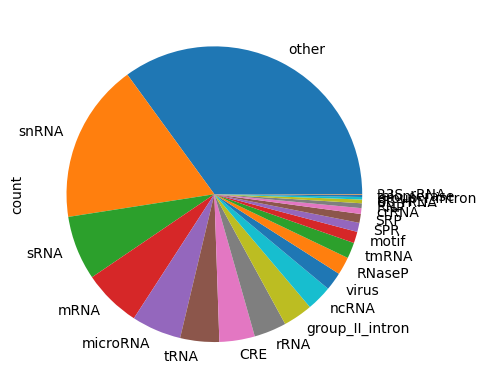

In [ ]:
pd.merge(df_final, df90, on='sequence', how='inner').family.value_counts().plot(kind='pie')